In [112]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

<h1>Make Multivariable Dataset</h1>
<h2>Load Chinook Data</h2>

In [113]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
    king_data = salmon_copy.filter(["date","king"], axis=1)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [114]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
    king_all_copy, king_data= load_data(ismael_path)
    print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [115]:
data_copy = king_all_copy
print(data_copy['date'])
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

0       1939-01-01
1       1939-01-02
2       1939-01-03
3       1939-01-04
4       1939-01-05
           ...    
24364   2020-12-25
24365   2020-12-26
24366   2020-12-27
24367   2020-12-28
24368   2020-12-29
Name: date, Length: 24369, dtype: datetime64[ns]


,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [116]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [117]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [118]:
data_copy

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [119]:
master_data = data_copy
master_data

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [120]:
master_data = master_data[132:]

In [121]:
master_data

,date,king
132,1950-01-31,0
133,1950-02-28,0
134,1950-03-31,21
135,1950-04-30,6630
136,1950-05-31,50638
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [122]:
master_data.reset_index(inplace=True)

In [123]:
master_data = master_data.drop(labels='index', axis=1)

In [124]:
print(master_data)

          date    king
0   1950-01-31       0
1   1950-02-28       0
2   1950-03-31      21
3   1950-04-30    6630
4   1950-05-31   50638
..         ...     ...
847 2020-08-31  105269
848 2020-09-30  254930
849 2020-10-31   30917
850 2020-11-30     843
851 2020-12-31       9

[852 rows x 2 columns]


<h2>Load Covariate Data and Concat to Master_Data</h2>

In [125]:
def load_cov_set(pathname):
    data = pd.read_csv(pathname)
    return data

In [126]:
ismael_path_cov = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/covariates.csv'
chris_path_cov = '/Users/chrisshell/Desktop/Stanford/SalmonData/Environmental Variables/salmon_env_use.csv'
abdul_path_cov= '/Users/abdul/Downloads/SalmonNet/salmon_env_use.csv'
cov_data = load_cov_set(ismael_path_cov)
cov_data

,year,month,upwelling,noi,npgo,pdo,oni
0,1950,1,-16,2.644,-2.190,-1.61,-1.40
1,1950,2,-166,2.077,-1.450,-2.17,-1.20
2,1950,3,-49,3.091,-0.970,-1.89,-1.10
3,1950,4,-4,1.923,-0.860,-1.99,-1.20
4,1950,5,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020,8,43,-0.463,-1.422,-1.32,-0.57
848,2020,9,-1,-0.276,-1.161,-1.03,-0.89
849,2020,10,10,1.612,-1.476,-0.62,-1.17
850,2020,11,-43,1.998,-1.710,-1.58,-1.27


In [127]:
upwelling = cov_data["upwelling"]
master_data = master_data.join(upwelling)
master_data

,date,king,upwelling
0,1950-01-31,0,-16
1,1950-02-28,0,-166
2,1950-03-31,21,-49
3,1950-04-30,6630,-4
4,1950-05-31,50638,49
...,...,...,...
847,2020-08-31,105269,43
848,2020-09-30,254930,-1
849,2020-10-31,30917,10
850,2020-11-30,843,-43


In [128]:
noi = cov_data["noi"]
master_data = master_data.join(noi)
master_data

,date,king,upwelling,noi
0,1950-01-31,0,-16,2.644
1,1950-02-28,0,-166,2.077
2,1950-03-31,21,-49,3.091
3,1950-04-30,6630,-4,1.923
4,1950-05-31,50638,49,2.211
...,...,...,...,...
847,2020-08-31,105269,43,-0.463
848,2020-09-30,254930,-1,-0.276
849,2020-10-31,30917,10,1.612
850,2020-11-30,843,-43,1.998


In [129]:
npgo = cov_data["npgo"]
master_data = master_data.join(npgo)
master_data

,date,king,upwelling,noi,npgo
0,1950-01-31,0,-16,2.644,-2.190
1,1950-02-28,0,-166,2.077,-1.450
2,1950-03-31,21,-49,3.091,-0.970
3,1950-04-30,6630,-4,1.923,-0.860
4,1950-05-31,50638,49,2.211,-0.630
...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422
848,2020-09-30,254930,-1,-0.276,-1.161
849,2020-10-31,30917,10,1.612,-1.476
850,2020-11-30,843,-43,1.998,-1.710


In [130]:
pdo = cov_data["pdo"]
master_data = master_data.join(pdo)
master_data

,date,king,upwelling,noi,npgo,pdo
0,1950-01-31,0,-16,2.644,-2.190,-1.61
1,1950-02-28,0,-166,2.077,-1.450,-2.17
2,1950-03-31,21,-49,3.091,-0.970,-1.89
3,1950-04-30,6630,-4,1.923,-0.860,-1.99
4,1950-05-31,50638,49,2.211,-0.630,-3.19
...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03
849,2020-10-31,30917,10,1.612,-1.476,-0.62
850,2020-11-30,843,-43,1.998,-1.710,-1.58


In [131]:
oni = cov_data["oni "]
master_data = master_data.join(oni)
master_data
# cov_data.columns

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


In [132]:
master_data = master_data.rename(columns={"oni ": "oni"})
master_data

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


<h2> Load and Concat NOI data </h2>

In [133]:
master_data.set_index('date', inplace=True)
master_data.index = pd.to_datetime(master_data.index)
master_data

,king,upwelling,noi,npgo,pdo,oni
date,,,,,,
1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...
2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17


In [134]:
master_data.to_csv('master_data.csv')

In [135]:
checkpoint_filepath = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/checkpoint'
chris_checkpoint_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Checkpoint'
abdul_checkpoint_path = '/Users/abdul/Downloads/SalmonNet/Checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

<h2>Let's plot each series</h2>

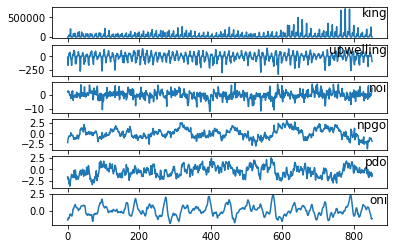

In [136]:
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=.5, loc='right')
    i += 1
plt.show()

<h2>Make Series into Train and Test Set with inputs and ouptuts</h2>

In [137]:
# convert series to supervised learning
# series_to_supervised from Jason Brownlee's "Multivariate Time Series Forecasting in Keras"
def series_to_supervised(data, n_in=6, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_months = 6
n_features = 6
reframed = series_to_supervised(scaled, n_months, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[13]], axis=1, inplace=True)
print(reframed.head())

    var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6    0.000006   0.520913   0.710488   0.220877   0.329032   0.119048   
7    0.000006   0.079848   0.683284   0.332829   0.238710   0.166667   
8    0.000035   0.399240   0.731936   0.405446   0.283871   0.190476   
9    0.009241   0.566540   0.675895   0.422088   0.267742   0.166667   
10   0.070540   0.764259   0.689713   0.456883   0.074194   0.190476   

    var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  ...  var3(t-1)  var4(t-1)  \
6    0.000006   0.079848   0.683284   0.332829  ...   0.632281   0.464448   
7    0.000035   0.399240   0.731936   0.405446  ...   0.567508   0.440242   
8    0.009241   0.566540   0.675895   0.422088  ...   0.572306   0.468986   
9    0.070540   0.764259   0.689713   0.456883  ...   0.591786   0.461422   
10   0.023221   0.703422   0.632281   0.464448  ...   0.461760   0.570348   

    var5(t-1)  var6(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
6    0.182258   0.238095  

In [138]:
# split into train and test sets
values = reframed.values
n_train_months = 66 * 12 # MENTAL NOTE: IF ERROR IN MOTH TO YEAR CHECK THIS
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
n_obs = n_months * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(792, 6, 6) (792,) (54, 6, 6) (54,)


In [139]:
X_train, X_dev, y_train, y_dev = train_test_split(train_X, train_y, test_size=0.10, shuffle=False)

In [140]:
print(X_dev.shape)
print(y_dev.shape)
print(X_train.shape)
print(y_train.shape)
print(test_X.shape)
print(test_y.shape)

(80, 6, 6)
(80,)
(712, 6, 6)
(712,)
(54, 6, 6)
(54,)


Epoch 1/1000
1/1 - 6s - loss: 0.1902 - root_mean_squared_error: 0.4361 - val_loss: 0.1280 - val_root_mean_squared_error: 0.3578
Epoch 2/1000
1/1 - 0s - loss: 0.1436 - root_mean_squared_error: 0.3789 - val_loss: 0.0922 - val_root_mean_squared_error: 0.3036
Epoch 3/1000
1/1 - 0s - loss: 0.1013 - root_mean_squared_error: 0.3182 - val_loss: 0.0638 - val_root_mean_squared_error: 0.2526
Epoch 4/1000
1/1 - 0s - loss: 0.0653 - root_mean_squared_error: 0.2555 - val_loss: 0.0448 - val_root_mean_squared_error: 0.2117
Epoch 5/1000
1/1 - 0s - loss: 0.0377 - root_mean_squared_error: 0.1941 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 6/1000
1/1 - 0s - loss: 0.0199 - root_mean_squared_error: 0.1409 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1954
Epoch 7/1000
1/1 - 0s - loss: 0.0121 - root_mean_squared_error: 0.1100 - val_loss: 0.0482 - val_root_mean_squared_error: 0.2197
Epoch 8/1000
1/1 - 0s - loss: 0.0130 - root_mean_squared_error: 0.1142 - val_loss: 0.0625 - val_root_mea

Epoch 40/1000
1/1 - 0s - loss: 0.0107 - root_mean_squared_error: 0.1034 - val_loss: 0.0453 - val_root_mean_squared_error: 0.2128
Epoch 41/1000
1/1 - 0s - loss: 0.0107 - root_mean_squared_error: 0.1036 - val_loss: 0.0450 - val_root_mean_squared_error: 0.2122
Epoch 42/1000
1/1 - 0s - loss: 0.0106 - root_mean_squared_error: 0.1031 - val_loss: 0.0445 - val_root_mean_squared_error: 0.2109
Epoch 43/1000
1/1 - 0s - loss: 0.0104 - root_mean_squared_error: 0.1021 - val_loss: 0.0437 - val_root_mean_squared_error: 0.2090
Epoch 44/1000
1/1 - 0s - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 0.0427 - val_root_mean_squared_error: 0.2066
Epoch 45/1000
1/1 - 0s - loss: 0.0099 - root_mean_squared_error: 0.0994 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2041
Epoch 46/1000
1/1 - 0s - loss: 0.0096 - root_mean_squared_error: 0.0982 - val_loss: 0.0407 - val_root_mean_squared_error: 0.2017
Epoch 47/1000
1/1 - 0s - loss: 0.0094 - root_mean_squared_error: 0.0972 - val_loss: 0.0398 - val_

Epoch 79/1000
1/1 - 0s - loss: 0.0088 - root_mean_squared_error: 0.0939 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1957
Epoch 80/1000
1/1 - 0s - loss: 0.0088 - root_mean_squared_error: 0.0939 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1958
Epoch 81/1000
1/1 - 0s - loss: 0.0088 - root_mean_squared_error: 0.0938 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1960
Epoch 82/1000
1/1 - 0s - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1962
Epoch 83/1000
1/1 - 0s - loss: 0.0088 - root_mean_squared_error: 0.0936 - val_loss: 0.0386 - val_root_mean_squared_error: 0.1965
Epoch 84/1000
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0935 - val_loss: 0.0387 - val_root_mean_squared_error: 0.1968
Epoch 85/1000
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0934 - val_loss: 0.0388 - val_root_mean_squared_error: 0.1971
Epoch 86/1000
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0933 - val_loss: 0.0390 - val_

Epoch 118/1000
1/1 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1963
Epoch 119/1000
1/1 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1962
Epoch 120/1000
1/1 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1961
Epoch 121/1000
1/1 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0915 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1961
Epoch 122/1000
1/1 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0915 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1961
Epoch 123/1000
1/1 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1960
Epoch 124/1000
1/1 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1960
Epoch 125/1000
1/1 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0914 - val_loss: 0.038

Epoch 157/1000
1/1 - 0s - loss: 0.0082 - root_mean_squared_error: 0.0903 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1954
Epoch 158/1000
1/1 - 0s - loss: 0.0082 - root_mean_squared_error: 0.0903 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1953
Epoch 159/1000
1/1 - 0s - loss: 0.0081 - root_mean_squared_error: 0.0903 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1953
Epoch 160/1000
1/1 - 0s - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1953
Epoch 161/1000
1/1 - 0s - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1952
Epoch 162/1000
1/1 - 0s - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1952
Epoch 163/1000
1/1 - 0s - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1952
Epoch 164/1000
1/1 - 0s - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.038

Epoch 196/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1943
Epoch 197/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1943
Epoch 198/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1943
Epoch 199/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942
Epoch 200/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942
Epoch 201/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942
Epoch 202/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942
Epoch 203/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.037

Epoch 235/1000
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0374 - val_root_mean_squared_error: 0.1933
Epoch 236/1000
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0374 - val_root_mean_squared_error: 0.1933
Epoch 237/1000
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0374 - val_root_mean_squared_error: 0.1933
Epoch 238/1000
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1932
Epoch 239/1000
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1932
Epoch 240/1000
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1932
Epoch 241/1000
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1932
Epoch 242/1000
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.037

Epoch 274/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1924
Epoch 275/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1923
Epoch 276/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1923
Epoch 277/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1923
Epoch 278/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1923
Epoch 279/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1922
Epoch 280/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1922
Epoch 281/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.036

Epoch 313/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0880 - val_loss: 0.0367 - val_root_mean_squared_error: 0.1915
Epoch 314/1000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0367 - val_root_mean_squared_error: 0.1915
Epoch 315/1000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0366 - val_root_mean_squared_error: 0.1914
Epoch 316/1000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0366 - val_root_mean_squared_error: 0.1914
Epoch 317/1000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0366 - val_root_mean_squared_error: 0.1914
Epoch 318/1000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0366 - val_root_mean_squared_error: 0.1914
Epoch 319/1000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0366 - val_root_mean_squared_error: 0.1913
Epoch 320/1000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.036

Epoch 352/1000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1907
Epoch 353/1000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 354/1000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 355/1000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 356/1000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 357/1000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 358/1000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1905
Epoch 359/1000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.036

Epoch 391/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1899
Epoch 392/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1899
Epoch 393/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1899
Epoch 394/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0360 - val_root_mean_squared_error: 0.1899
Epoch 395/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0360 - val_root_mean_squared_error: 0.1898
Epoch 396/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0360 - val_root_mean_squared_error: 0.1898
Epoch 397/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0360 - val_root_mean_squared_error: 0.1898
Epoch 398/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.036

Epoch 430/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1892
Epoch 431/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1892
Epoch 432/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1892
Epoch 433/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1892
Epoch 434/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1892
Epoch 435/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1891
Epoch 436/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1891
Epoch 437/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.035

Epoch 469/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0869 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1886
Epoch 470/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0869 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1886
Epoch 471/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0869 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1885
Epoch 472/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1885
Epoch 473/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1885
Epoch 474/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1885
Epoch 475/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1885
Epoch 476/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.035

Epoch 508/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1880
Epoch 509/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1879
Epoch 510/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1879
Epoch 511/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1879
Epoch 512/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1879
Epoch 513/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1879
Epoch 514/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1879
Epoch 515/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.035

Epoch 547/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0863 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1873
Epoch 548/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0863 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1873
Epoch 549/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0863 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1873
Epoch 550/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0863 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1873
Epoch 551/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0863 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1873
Epoch 552/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1873
Epoch 553/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1873
Epoch 554/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.035

Epoch 586/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0861 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1868
Epoch 587/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0861 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1867
Epoch 588/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0861 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1867
Epoch 589/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0861 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1867
Epoch 590/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1867
Epoch 591/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1867
Epoch 592/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1867
Epoch 593/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.034

Epoch 625/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1862
Epoch 626/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1861
Epoch 627/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1861
Epoch 628/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1861
Epoch 629/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1861
Epoch 630/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1861
Epoch 631/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1861
Epoch 632/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0857 - val_loss: 0.034

Epoch 664/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1855
Epoch 665/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1855
Epoch 666/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1855
Epoch 667/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1855
Epoch 668/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1855
Epoch 669/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1854
Epoch 670/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1854
Epoch 671/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.034

Epoch 703/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1848
Epoch 704/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0851 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1848
Epoch 705/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1848
Epoch 706/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1848
Epoch 707/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1848
Epoch 708/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1847
Epoch 709/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1847
Epoch 710/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.034

Epoch 742/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1840
Epoch 743/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0338 - val_root_mean_squared_error: 0.1840
Epoch 744/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0338 - val_root_mean_squared_error: 0.1840
Epoch 745/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0338 - val_root_mean_squared_error: 0.1839
Epoch 746/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0338 - val_root_mean_squared_error: 0.1839
Epoch 747/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0338 - val_root_mean_squared_error: 0.1839
Epoch 748/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0338 - val_root_mean_squared_error: 0.1839
Epoch 749/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.033

Epoch 781/1000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1830
Epoch 782/1000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1830
Epoch 783/1000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1830
Epoch 784/1000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1829
Epoch 785/1000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1829
Epoch 786/1000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0334 - val_root_mean_squared_error: 0.1829
Epoch 787/1000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0842 - val_loss: 0.0334 - val_root_mean_squared_error: 0.1828
Epoch 788/1000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0842 - val_loss: 0.033

Epoch 820/1000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1819
Epoch 821/1000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1818
Epoch 822/1000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1818
Epoch 823/1000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1818
Epoch 824/1000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1817
Epoch 825/1000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1817
Epoch 826/1000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1817
Epoch 827/1000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.033

Epoch 859/1000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1806
Epoch 860/1000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1805
Epoch 861/1000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1805
Epoch 862/1000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1805
Epoch 863/1000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1804
Epoch 864/1000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1804
Epoch 865/1000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1804
Epoch 866/1000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.032

Epoch 898/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0828 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1792
Epoch 899/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1792
Epoch 900/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1792
Epoch 901/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1791
Epoch 902/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1791
Epoch 903/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1791
Epoch 904/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1790
Epoch 905/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.032

Epoch 937/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1778
Epoch 938/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1778
Epoch 939/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1778
Epoch 940/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1777
Epoch 941/1000
1/1 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0822 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1777
Epoch 942/1000
1/1 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1776
Epoch 943/1000
1/1 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1776
Epoch 944/1000
1/1 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.031

Epoch 976/1000
1/1 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0311 - val_root_mean_squared_error: 0.1763
Epoch 977/1000
1/1 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0311 - val_root_mean_squared_error: 0.1762
Epoch 978/1000
1/1 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1762
Epoch 979/1000
1/1 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1761
Epoch 980/1000
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1761
Epoch 981/1000
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1760
Epoch 982/1000
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1760
Epoch 983/1000
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.031

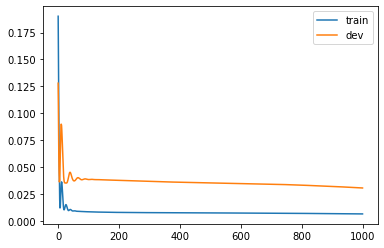

In [141]:
# design network
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(GRU(1))
# model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',  metrics=[tf.keras.metrics.RootMeanSquaredError()])
# fit network
#  
history = model.fit(train_X, train_y, epochs=1000, batch_size=1000, validation_data=(X_dev, y_dev), verbose=2, shuffle=False, callbacks=[model_checkpoint_callback])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

In [142]:
# make a prediction
yhat = model.predict(test_X)
train_yhat = model.predict(train_X)

In [143]:
test_X = test_X.reshape((test_X.shape[0], n_months*n_features))
train_X = train_X.reshape((train_X.shape[0], n_months*n_features))

In [144]:
# invert scaling for forecast
inv_yhat_train = concatenate((train_yhat, train_X[:, -5:]), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_train = concatenate((train_y, train_X[:, -5:]), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]

In [145]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [146]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
def month_to_year(month_preds):
    month_preds = month_preds[6:]
    year_preds = []
    for i in range(12, len(month_preds) + 1, 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The test root mean squared error is {}.".format(rmse))

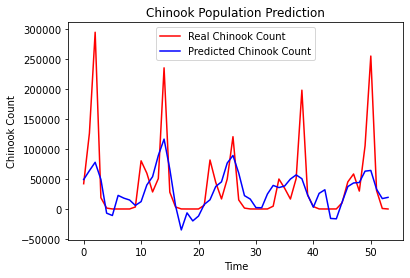

The test root mean squared error is 53364.70144205812.


In [147]:
plot_predictions(inv_y, inv_yhat)
return_rmse(inv_y, inv_yhat)

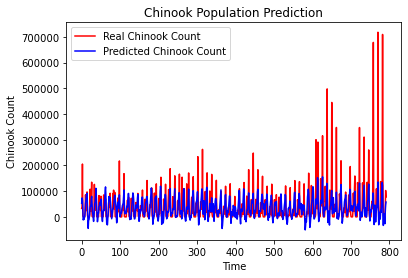

The test root mean squared error is 58259.14410631176.


In [148]:
plot_predictions(inv_y_train, inv_yhat_train)
return_rmse(inv_y_train, inv_yhat_train)

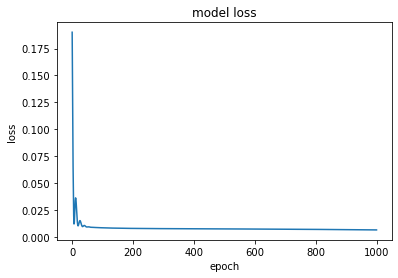

In [149]:
plot_loss(history)

In [150]:
preds = month_to_year(inv_yhat).astype(np.int64)
actual = month_to_year(inv_y).astype(np.int64)
print(preds)
print(actual)

    Count
0  410131
1  332086
2  352166
3  333230
    Count
0  488981
1  336030
2  381773
3  535746


In [151]:
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_ismael_path)
traditional = pd.DataFrame(baseline_data["Count"])
print(traditional)

    Count
0  498710
1  439060
2  294840
3  347600


In [152]:
return_rmse(actual, traditional)

The test root mean squared error is 115829.72216361394.


In [153]:
return_rmse(actual, preds)

The test root mean squared error is 109683.84377496077.
